# 0. Notes

- To run this notebook you will need to [install jupyter](https://jupyter.org/install)
    - If working in VSCode (which we recommend), you will need to activate your python environment by selecting the appropriate kernel
- The functions you need to implement are **very short**. If the first thing you do is start writing code you will struggle. You need to understand the **inputs and outputs** of each method and understand how to use **numpy** operations to avoid the use of for loops.
- You **do not** need to submit to gradescope, we supply all necessary tests in tests.py

# 1. Setting up linear regression

In this part of the assignment you will set up the necessary code for doing linear regression. Namely you will implement:
- create_linear_data(num_samples, slope, intercept, x_range, noise)
- get_simple_linear_features(x)
- linear_prediction(x, A, get_modified_features)
- mse_loss(y_pred, y_true)
- compute_model_error(x, y, A, get_modified_features)

We'll tackle these one at a time below.

In [63]:
# some generic useful imports - this is ALL you need
import numpy as np
import matplotlib.pyplot as plt
import importlib
import tests
# the lines below ensure that you can modify mp1.py and imported files update accordingly
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## create_linear_data

To do linear regression (or any machine learning) we need data. 

For now you will be *synthesizing* your own data. Given a `slope` and `intercept` you will create and return artificial `x` and noisy `y` values. `x` should be uniformly sampled between `x_range[0]` and `x_range[1]`. You should create `num_samples` `x` values, compute `y = slope * x + intercept`, and then add some uniform noise sampled between `-noise` and `noise`.

You will find `np.random.rand` useful for sampling both the `x` values and the uniform noise.

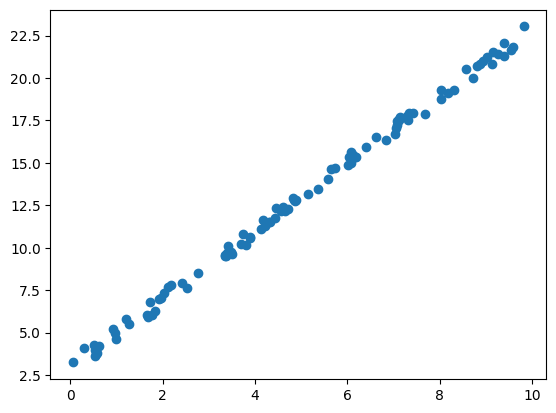

In [64]:
# TODO: fill in the create_linear_data function
# NOTE: DO NOT use for loops
from mp1 import create_linear_data

num_samples = 100
slope = 2
intercept = 3
x_range = [0, 10]
noise = 0.5
x, y = create_linear_data(num_samples, slope, intercept, x_range, noise)
# plot
plt.scatter(x, y)
plt.show()

In [65]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_create_linear_data(num_samples=10, slope=2, intercept=-1, x_range=[-10,10], noise=0)
tests.test_create_linear_data(num_samples=10, slope=-3, intercept=2, x_range=[0,5], noise=0.2)

## get_simple_linear_features and linear_prediction

An extremely important concept in machine learning is **vectorization**.

Instead of writing $y_i=mx_i+b$ for some data $(x_i, y_i)$ we prefer writing $\mathbf{a}=\begin{bmatrix} m \\ b \end{bmatrix}, \mathbf{X}_i=\begin{bmatrix} x_i & 1 \end{bmatrix}$, and thus $y_i=\mathbf{X}_i\mathbf{a}$. Note that $\mathbf{X}_i$ is a $(1,2)$ matrix and $\mathbf{A}$ is a $(2,1)$ vector and so the output $y_i$ is $(1,1)$.

Having written things in this way we now no longer think of "slopes" and "intercepts" but rather generic "features". Our features ($\mathbf{X}_i$) get multipled by these **parameters** ($\mathbf{A}$) to compute our output ($y_i$). After this transformation we can think of our input as $2$-dimensional (even though the second dimension is always equal to $1$) and our output as $1$-dimensional. Later in this assignment you'll see how we can modify these features further.

Now we can go further and write down predicted y values for the entire dataset as one matrix multiplication!
$$\mathbf{y} = \begin{bmatrix} y_{0} \\ y_{1} \\ \vdots \\ y_{n-1} \end{bmatrix}, \mathbf{X} = \begin{bmatrix} x_{0} & 1 \\ x_{1} & 1 \\ \vdots & \vdots \\ x_{n-1} & 1 \end{bmatrix} \implies \mathbf{y} = \mathbf{X}\mathbf{a}$$

We can now basically summarize our goal as "find the matrix A which gives good predictions across our dataset". We'll look at what "good" means in the next section but first let's implement some methods that compute $\mathbf{X}$ given $x$ and predict $\mathbf{y}$ given $\mathbf{X}$ and $\mathbf{a}$.

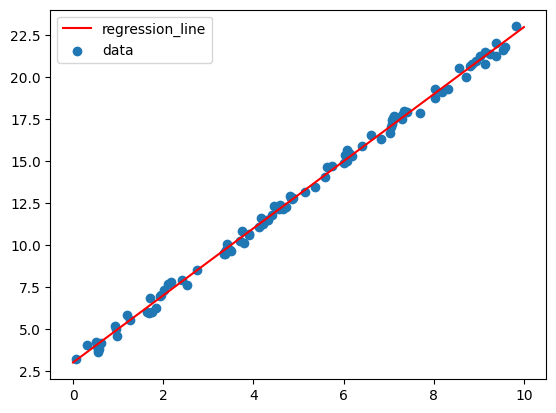

In [66]:
# TODO: fill in the get_simple_linear_features and linear_prediction functions
# NOTE: our solution is ONE line of code for each function! DO NOT use for loops.
#       You should use methods like np.concatenate, np.ones, and np.dot
from mp1 import get_simple_linear_features, linear_prediction

# get x_values for plotting the line
x_plot = np.linspace(x_range[0], x_range[1], 1000).reshape(-1, 1)
# now make a matrix A of shape (2, 1) with the slope and intercept
A_true = np.array([[slope], [intercept]])
# now make a prediction
y_hat = linear_prediction(x_plot, A_true, get_simple_linear_features)
# now plot the data and the prediction
plt.plot(x_plot, y_hat, color='red', label="regression_line")
plt.scatter(x, y, label='data')
plt.legend()
plt.show()

In [67]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_get_simple_linear_features(num_samples=10, num_features=1)
tests.test_get_simple_linear_features(num_samples=1, num_features=4)
tests.test_linear_prediction()

## mse_loss and compute_model_error 

Above we said our goal is to find parameters that make "good" predictions. But what does good mean? In our case, we will look for the set of parameters that *minimize a loss function*. In particular we will use the Mean Squared Error:
$$\mathrm{MSE}(\mathbf{y}, \bar{\mathbf{y}}) = \frac{1}{n}\sum_i (y_i - \bar{y_i})^2$$
where $\bar{\mathbf{y}}$ are the true values and $\mathbf{y}$ are our predictions.

Thanks to our vectorization from before we can simply rewrite this as:
$$\mathrm{MSE}(\mathbf{y}, \bar{\mathbf{y}}) = \frac{1}{n}||\mathbf{y} - \bar{\mathbf{y}}||_2^2 = \frac{1}{n}(\mathbf{y} - \bar{\mathbf{y}})^T(\mathbf{y}- \bar{\mathbf{y}})$$

and since our predictions are $\mathbf{y} = \mathbf{X}\mathbf{a}$ our model error is:
$$L(\mathbf{a}, \mathbf{X}, \bar{\mathbf{y}}) = \frac{1}{n}||\mathbf{X}\mathbf{a} - \bar{\mathbf{y}}||_2^2$$

NOTE: The notation $||\cdot||_2$ is the $2$-norm, or Euclidean norm, of a vector. So the loss above is the squared $2$-norm.

In [68]:
# TODO: fill in the mse_loss function
# NOTE: our solution is ONE line of code! Use numpy operations not for loops!
from mp1 import compute_model_error

x, y = create_linear_data(num_samples, slope, intercept, x_range, noise)

perfect_model = np.array([[slope], [intercept]])
perfect_error = compute_model_error(x, y, perfect_model, get_simple_linear_features)

bad_model = np.array([[slope + 1], [intercept + 1]])
bad_error = compute_model_error(x, y, bad_model, get_simple_linear_features)

really_bad_model = np.array([[-slope], [-intercept]])
really_bad_error = compute_model_error(x, y, really_bad_model, get_simple_linear_features)

# NOTE: perfect error is not zero because of the noise
print(f"Perfect model error: {perfect_error}")
print(f"Bad model error: {bad_error}")
print(f"Really bad model error: {really_bad_error}")

Perfect model error: [[0.0912494]]
Bad model error: [[45.69449576]]
Really bad model error: [[829.70129886]]


In [69]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_mse_loss()

# 2. Analytical linear regression

Great, so we have data, we can vectorize it, and we can compute some error. But how do we actually find the right set of parameters? The answer is to *minimize the loss*. There are many ways to minimize a function, first we'll look at a simple approach from calculus: to minimize a function take the derivative, set it equal to zero, and solve the equation.

Specifically, we take the partial derivative of our *loss* with respect to our *parameters*:

$$\frac{\partial\mathcal{L}}{\partial\mathbf{a}} = \frac{\partial}{\partial\mathbf{a}} \left(\frac{1}{n}||\mathbf{X}\mathbf{a}-\mathbf{y}||_2^2\right)$$
$$= \frac{\partial}{\partial\mathbf{a}} \frac{1}{n}\left(\mathbf{X}\mathbf{a}-\mathbf{y}\right)^T\left(\mathbf{X}\mathbf{a}-\mathbf{y}\right)$$
$$= \frac{2}{n}\mathbf{X}^T(\mathbf{X}\mathbf{a}-\mathbf{y}) = 0$$
$$\implies \mathbf{X}^T(\mathbf{X}\mathbf{a}-\mathbf{y}) = 0$$
$$\implies \mathbf{X}^T\mathbf{X}\mathbf{a}-\mathbf{X}^T\mathbf{y} = 0$$
$$\implies \mathbf{X}^T\mathbf{X}\mathbf{a} = \mathbf{X}^T\mathbf{y}$$
$$\implies \mathbf{a} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \mathbf{y}$$

You're not expected to know/understand matrix derivatives but you can intuitively see how we got the above derivative by imagining these were real numbers: if we had no matrices, our loss would maybe look like $\mathcal{L}(a,x,y) = (ax - y)^2$, and the derivative of this with respect to $a$ is just $2x(ax-y)$ (which is basically what we got above just without any transposes...).

Fill in the function `analytical_linear_regression` with the above expression to compute $A$ given $X$ and $y$.

True slope: 2, True intercept: 3
Predicted slope: 2.0031277623603208, Predicted intercept: 3.0043111320248013


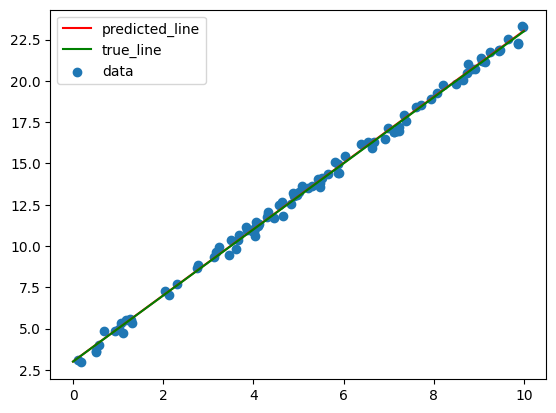

True slope: 2, True intercept: 3
Predicted slope: 1.6996406043738672, Predicted intercept: 4.2268279234867485


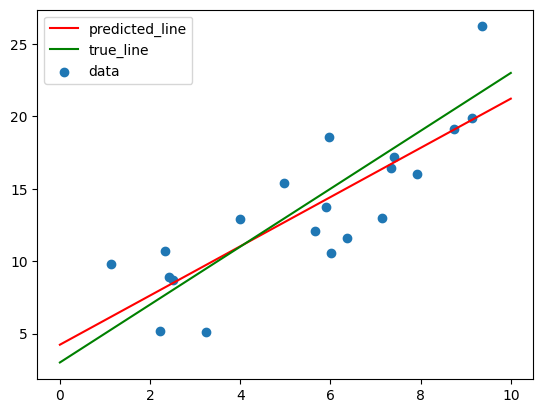

In [70]:
# TODO: fill in the analytical_linear_regression function. DO NOT use for loops!
from mp1 import analytical_linear_regression
# create data
num_samples = 100
slope = 2
intercept = 3
x_range = [0, 10]
noise = 0.5
x, y = create_linear_data(num_samples, slope, intercept, x_range, noise)
# transform x into features (add column of 1's)
X = get_simple_linear_features(x)
# find the analytical solution
predicted_A = analytical_linear_regression(X, y)
print(f"True slope: {slope}, True intercept: {intercept}")
print(f"Predicted slope: {predicted_A[0, 0]}, Predicted intercept: {predicted_A[1, 0]}")

# plot
y_hat = linear_prediction(x_plot, predicted_A, get_simple_linear_features)
y_true = linear_prediction(x_plot, perfect_model, get_simple_linear_features)
plt.plot(x_plot, y_hat, color='red', label="predicted_line")
plt.plot(x_plot, y_true, color='green', label="true_line")
plt.scatter(x, y, label='data')
plt.legend()
plt.show()

# Now see what happens with larger noise and few samples
num_samples = 20
large_noise = 5.0
x, y = create_linear_data(num_samples, slope, intercept, x_range, large_noise)
X = get_simple_linear_features(x)
predicted_A = analytical_linear_regression(X, y)
print(f"True slope: {slope}, True intercept: {intercept}")
print(f"Predicted slope: {predicted_A[0, 0]}, Predicted intercept: {predicted_A[1, 0]}")

# plot
y_hat = linear_prediction(x_plot, predicted_A, get_simple_linear_features)
y_true = linear_prediction(x_plot, perfect_model, get_simple_linear_features)
plt.plot(x_plot, y_hat, color='red', label="predicted_line")
plt.plot(x_plot, y_true, color='green', label="true_line")
plt.scatter(x, y, label='data')
plt.legend()
plt.show()

In [71]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_analytical_linear_regression()

# 3. Gradient descent

In practice (i.e., with neural networks) we can *take* the derivative but *NOT solve for when it is equal to zero*. Now you will implement an algorithm, gradient descent, which uses the derivative to iteratively update the parameters. As above, our derivative is:

$$\frac{\partial\mathcal{L}}{\partial\mathbf{a}} = \frac{2}{n}\mathbf{X}^T(\mathbf{X}\mathbf{a}-\mathbf{y})$$

Gradient descent simply computes:
$$\mathbf{a}_{new} = \mathbf{a}_{old} - \alpha \frac{\partial\mathcal{L}}{\partial\mathbf{a}_{old}}$$

where $\alpha$ is a learning rate. 

Now implement `get_linear_regression_gradient` and `gradient_descent` functions...
- Notice how gradient_descent takes as input a function called get_gradient which only depends on the parameters - see the code example below for how we pass `get_linear_regression_gradient` into `gradient_descent`
- Notice the TODO below - you should modify the `learning_rate` and `num_iterations` yourself until you get good results...

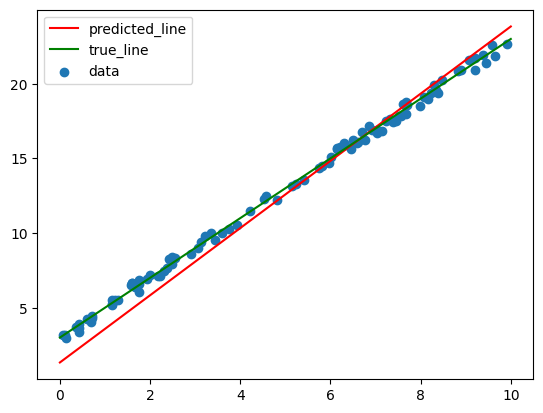

In [72]:
from mp1 import get_linear_regression_gradient, gradient_descent

# initialize data
num_samples = 100
slope = 2
intercept = 3
x_range = [0, 10]
noise = 0.5
x, y = create_linear_data(num_samples, slope, intercept, x_range, noise)
X = get_simple_linear_features(x)

# random initialization of parameters
A_init = np.random.randn(2, 1)

# TODO: play around with these parameters to see how they affect the results
learning_rate = 0.001
num_iterations = 1000

# *** notice how we fix X and y as inputs to get_linear_regression_gradient in order to compute get_gradient ***
get_gradient = lambda A: get_linear_regression_gradient(A, X, y)

# do gradient descent
predicted_A = gradient_descent(get_gradient, A_init, learning_rate, num_iterations)

# plot
y_hat = linear_prediction(x_plot, predicted_A, get_simple_linear_features)
y_true = linear_prediction(x_plot, perfect_model, get_simple_linear_features)
plt.plot(x_plot, y_hat, color='red', label="predicted_line")
plt.plot(x_plot, y_true, color='green', label="true_line")
plt.scatter(x, y, label='data')
plt.legend()
plt.show()

In [73]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_linear_regression_gradient()
tests.test_gradient_descent()

## Stochastic gradient descent (SGD)

Imagine we had a $1,000,000$ data points (which is a small fraction of the amount of data used to train models like GPT). In every iteration of gradient descent we did computation using all the data at once only to make a small update to our parameters. This can be quite slow - for example if we had $100$ features (GPT uses thousands) this would entail doing over $100,000,000$ mathematical operations just to compute $\mathbf{X}\mathbf{a}$!

Stochastic gradient descent makes a simple change to gradient descent - each time we want to update our parameters we will sample a batch of data from our dataset and compute the gradient using just that batch. This means our gradient is a *worse approximation of the true gradient* (remember that our data has noise and so our gradient is noisy). As a result we usually have to lower the learning rate a little (you can think of learning rate as how much you trust the direction the gradient is telling you to go).

Now implement SGD - each epoch should represent one pass through the entire dataset, and each pass should randomly order the data and then update in batches.
- Notice how `stochastic_gradient_descent` uses a `get_batch_gradient` function instead of `get_gradient`. The only difference is that `get_batch_gradient` takes as input a list of indices and then subselects from the data to compute the gradient. Again, see below for sample usage.

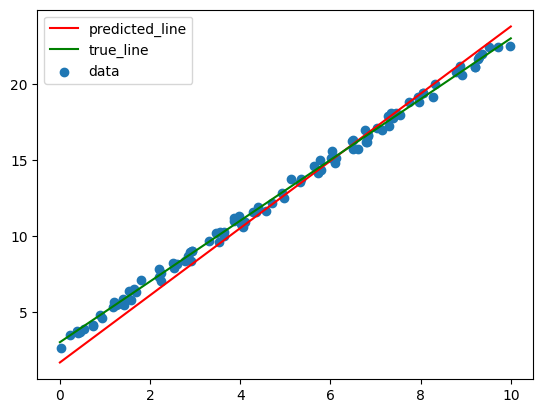

In [74]:
# TODO: fill in the stochastic_gradient_descent function
from mp1 import stochastic_gradient_descent

# initialize data
num_samples = 100
slope = 2
intercept = 3
x_range = [0, 10]
noise = 0.5
x, y = create_linear_data(num_samples, slope, intercept, x_range, noise)
X = get_simple_linear_features(x)

# stochastic gradient descent parameters 
A_init = np.random.randn(2, 1)
learning_rate = 0.01
num_epochs = 10
batch_size = 10
data_size = len(x)
# *** notice how we now take indices as input to get a subset of the data ***
get_batch_gradient = lambda A, indices: get_linear_regression_gradient(A, X[indices], y[indices])

predicted_A = stochastic_gradient_descent(
    get_batch_gradient, A_init, learning_rate, num_epochs, data_size, batch_size)

# plot
y_hat = linear_prediction(x_plot, predicted_A, get_simple_linear_features)
y_true = linear_prediction(x_plot, perfect_model, get_simple_linear_features)
plt.plot(x_plot, y_hat, color='red', label="predicted_line")
plt.plot(x_plot, y_true, color='green', label="true_line")
plt.scatter(x, y, label='data')
plt.legend()
plt.show()

In [75]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_stochastic_gradient_descent()

# 4. Sine data and feature transforms

Now we will fit a function to sine data still using linear regression. How is this possible - a line cannot fit a sine curve?! 

First let's create synthetic data. The `create_sine_data(num_samples, x_range, noise)` function should create data of the form $y_i = \sin(x_i) + \epsilon_i$ for:
- $0 \leq i < \mathrm{num\_samples}$
- $x_i \sim U(\mathrm{x\_range}[0], \mathrm{x\_range}[1])$
- $\epsilon_i \sim U(-\mathrm{noise}, \mathrm{noise})$.

where $U(a,b)$ means uniform distribution between $a$ and $b$.

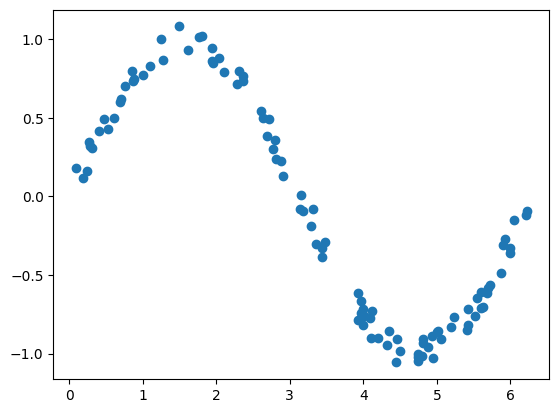

In [76]:
# TODO: fill in the create_sine_data function
from mp1 import create_sine_data

num_samples = 100
x_range = [0, 2 * np.pi]
noise = 0.1
x, y = create_sine_data(num_samples, x_range, noise)

# plot
plt.scatter(x, y)
plt.show()

In [77]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_create_sine_data()

## get_polynomial_features

Obviously a linear function cannot fit this data... but a polynomial function could. In order to do polynomial regression we would need to modify our model from $y=mx+b$ to $y=a_k x^k + a_{k-1} x^{k-1} + \dots + a_1 x + a_0$ for some degree $k$.

The easiest way to think of this is as a feature transform. Before we "transformed" our features as follows:

$$\mathbf{X} = \begin{bmatrix} x_{0} \\ x_{1} \\ \vdots \\ x_{n-1} \end{bmatrix} \to \mathbf{X}_{linear} = \begin{bmatrix} x_{0} & 1 \\ x_{1} & 1 \\ \vdots & \vdots \\ x_{n-1} & 1 \end{bmatrix}$$

We can actually think of this as:
$$\mathbf{X}_{linear} = \begin{bmatrix} \mathbf{X}^1 & \mathbf{X}^0 \end{bmatrix}$$

Now we will compute a new more general transform:
$$\mathbf{X}_{polynomial} = \begin{bmatrix} \mathbf{X}^k & \mathbf{X}^{k-1} & \dots & \mathbf{X}^0 \end{bmatrix}$$

For example, if $\mathbf{X}$ has $1$-dimensional features...
$$\mathbf{X} = \begin{bmatrix} x_{0} \\ x_{1} \\ \vdots \\ x_{n-1} \end{bmatrix}\implies \mathbf{X}_{polynomial} = \begin{bmatrix} x_0^k & x_0^{k-1} & \dots & x_{0} & 1 \\ x_1^k & x_1^{k-1} & \dots & x_{1} & 1 \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ x_{n-1}^k & x_{n-1}^{k-1} & \dots & x_{n-1} & 1 \end{bmatrix}$$

Or if $\mathbf{X}$ has $2$-dimensional features...
$$\mathbf{X} = \begin{bmatrix} x_{0,0} & x_{0,1} \\ x_{1,0} & x_{1,1} \\ \vdots \\ x_{n-1,0} & x_{n-1,1} \end{bmatrix}\implies \mathbf{X}_{polynomial} = \begin{bmatrix} x_{0,0}^k & x_{0,1}^k & x_{0,0}^{k-1} & x_{0,1}^{k-1} \dots & x_{0,0} & x_{0,1} & 1 & 1 \\ x_{1,0}^k & x_{1,1}^k & x_{1,0}^{k-1} & x_{1,1}^{k-1} \dots & x_{1,0} & x_{1,1} & 1 & 1 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\ x_{n-1,0}^k & x_{n-1,1}^k & x_{n-1,0}^{k-1} & x_{n-1,1}^{k-1} \dots & x_{n-1,0} & x_{n-1,1} & 1 & 1 \end{bmatrix}$$
Though it is a lot simpler to think of this as stacked exponents of the entire matrix $\mathbf{X}$.

- Notice that if $\mathbf{X}$ has shape $(n, m)$ then $\mathbf{X}_{polynomial}$ has shape $(n, m(k+1))$, which means our parameter vector $\mathbf{a}$ will now have shape $(m(k+1), 1)$. After this feature transform we can once again do plain old linear regression, meaning compute $mathbf{a}$ such that the MSE loss is minimized for model $\mathbf{y} = \mathbf{X}\mathbf{a}$...
- Notice the TODO below, you should play around with the degree of the polynomial (obviously `degree=1` is insufficient)

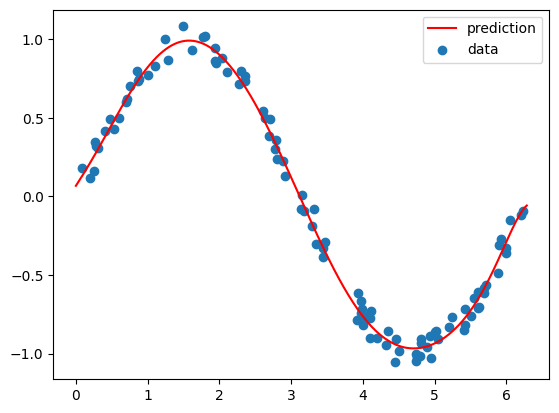

In [78]:
# TODO: fill in the get_polynomial_features function
from mp1 import get_polynomial_features

# TODO: you should change the degree to see how the model fits the data
degree = 10
X = get_polynomial_features(x, degree=degree)
# NOTE: we're using analytical linear regression here, 
# but you can substitute in gradient descent or stochastic gradient descent
A_sine = analytical_linear_regression(X, y)

# plot
x_plot = np.linspace(x_range[0], x_range[1], 1000).reshape(-1, 1)
y_hat = linear_prediction(x_plot, A_sine, lambda x: get_polynomial_features(x, degree=degree))
plt.plot(x_plot, y_hat, color='red', label="prediction")
plt.scatter(x, y, label='data')
plt.legend()
plt.show()

In [79]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_get_polynomial_features(num_data=10, num_features=1, degree=3)
tests.test_get_polynomial_features(num_data=10, num_features=2, degree=3)
tests.test_get_polynomial_features(num_data=100, num_features=1, degree=1)

# 5. Inverse kinematics via gradient descent

The gradient descent algorithm is extremely general and is used in a wide range of applications. We will now see a (simplified) application to robotics, namely inverse kinematics. 

In robotics, forward kinematics refers to the process of computing geometries from configurations. For example, if our robot is a rectangle at position $(x,y,\theta)$, where $\theta$ is its orientation, then forward kinematics here refers to finding the coordinates of the four corners of this rotated rectangle. Or if our robot is an arm with three joints described by their respective angles $(\theta_1, \theta_2, \theta_3)$, then forward kinematics is computing the three line segments (or cylinders, depending on how we represent our robot) for the three joints.

Inverse kinematics is the reverse - given a desired position in the real world compute a configuration that achieves this position. For example, in the case of the 3 joint arm, given an $(x,y)$ coordinate for the tip of the arm, also called the end-effector, find joint angles such that the end-effector is at that coordinate. This is a one-to-many function. Think of putting your hand on a table and then moving your elbow - your hand stays put but the joint configuration of your arm changes.

Let's meet our robot.

Our robot has (4, 2) endpoints
The arm base is fixed at (0,0)
The end effector position is [ 2.41011147 -1.01590988]


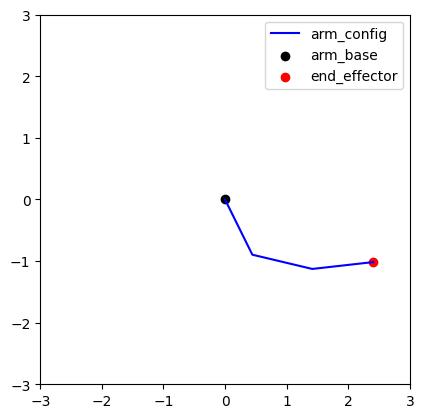

In [80]:
# TODO: you don't need to write any code, but you should familiarize yourself with the Arm class
#       namely you should understand what the code below is doing, you may want to play around with it a little
from planar_arm import Arm

# create an Arm object with 3 joints, each has length 1
num_joints = 3
arm_lengths = np.ones(num_joints)
arm = Arm(arm_lengths=arm_lengths)
# draw_space sets the axis limits
arm.draw_space(plt.gca())

# now define a configuration for the arm - meaning 3 joint angles
# NOTE: joint angles are in degrees
config = np.random.rand(num_joints) * 360
# draw the configuration
arm.draw_config(plt.gca(), config, color='blue', label='arm_config')
plt.scatter(0, 0, color='black', label='arm_base')

# compute the end effector position
# forward_kinematics returns the (x,y) positions of each joint and the end effector
forward_kinematics = arm.forward_kinematics(config)
print(f"Our robot has {forward_kinematics.shape} endpoints")
end_effector = forward_kinematics[-1]
print("The arm base is fixed at (0,0)")
print(f"The end effector position is {end_effector}")
# plot the end effector
plt.scatter(end_effector[0], end_effector[1], color='red', label='end_effector')

plt.legend()
plt.show()

## ik_loss

In order to do gradient descent we need a loss function. Fill in the `ik_loss` function which should simply compute the euclidean distance between the end effector and some goal position (you may find `np.linalg.norm` useful).

Also note we've provided a more complex loss function that uses ik_loss and also computes a loss with respect to obstacles. The code below samples random configurations of the arm until one of them has a loss less than $0.1$ (meaning the end effector is close to the goal position). This is one way of doing inverse kinematics but we'll discuss below a better alternative.  

Final loss after 19 samples: 0.09755196807040784


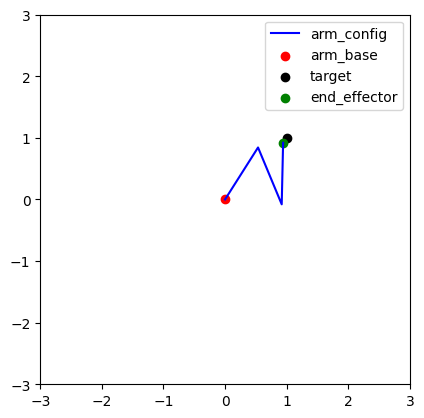

In [81]:
# TODO: fill in the ik_loss function
from mp1 import ik_loss

# let's say we want the end effector to be at (1, 1)
target = np.array([1, 1])

# we will keep sampling configurations until we get close...
config = np.random.rand(num_joints) * 360
num_attempts = 0
max_error = 0.1
while ik_loss(arm, config, target) > max_error:
    config = np.random.rand(num_joints) * 360
    num_attempts += 1
final_loss = ik_loss(arm, config, target)
print(f"Final loss after {num_attempts} samples: {final_loss}")

arm.draw_space(plt.gca())
arm.draw_config(plt.gca(), config, color='blue', label='arm_config')
plt.scatter(0, 0, color='red', label='arm_base')
plt.scatter(target[0], target[1], color='black', label='target')
end_effector = arm.forward_kinematics(config)[-1]
plt.scatter(end_effector[0], end_effector[1], color='green', label='end_effector')

plt.legend()
plt.show()

In [82]:
# do not move on until these tests pass (they should print nothing if they pass)
tests.test_ik_loss()

## estimate_ik_gradient and sample_near

Sampling randomly works but is not a great strategy for two main reasons:
- As the number of joints increases we will need exponentially more samples - try it above. 
- In practice we not only want the final configuration but a path to it. In previous assignments you saw how we could do this by discretizing the continuous space. Now we will see how gradient descent can solve this same planning problem. 

Gradients can be computed (as we did earlier) but they can also be approximated. In simplest terms, our goal is to know which direction to update our parameters such that our function value decreases. This is exactly what the negative gradient describes (which is why gradient descent does "minus"). We will now approximate the direction to update by sampling nearby parameter values and finding the one that gives the largest decrease in loss.

Implement `sample_near`, a function which takes a configuration (in our case the configuration represents our parameter values) and samples nearby configurations uniformly.

Next implement `estimate_ik_gradient`, a function which samples near a configuration, computes the loss at these neighboring configurations, and returns a (**unit**) vector pointing from the current configuration to the sample with **highest** loss.

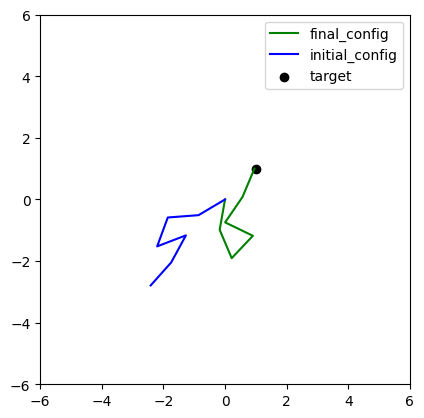

[149.36787157  26.33168882 294.55239684 228.78896802 139.46121925
  13.25375817]
5.100165548093062
[100.01388506 -33.02548203 246.43529426 252.3275043   98.57428926
 -11.48542967]
0.04431881568355431
1.4142135623730951


In [83]:
# TODO: fill in the estimate_ik_gradient function
from mp1 import estimate_ik_gradient

# create an Arm object with 3 joints, each has length 1
num_joints = 6
arm_lengths = np.ones(num_joints)
arm = Arm(arm_lengths=arm_lengths)

# let's say we want the end effector to be at (1, 1)
target = np.array([1, 1])
# we sample num_sample_near configurations to estimate the gradient at each point
num_sample_near = 20
# our gradient with respect to a config given the target and loss function
loss = lambda config: ik_loss(arm, config, target)
get_gradient = lambda config: estimate_ik_gradient(loss, config, num_samples=num_sample_near)

# gradient descent parameters
config_init = np.random.rand(num_joints) * 360 # random initialization, this is like A_init
learning_rate = 1.0 # notice a much higher learning rate
num_iterations = 1000 # with 1000 iterations we will get much closer to the target than before with over 1000 samples
final_config = gradient_descent(get_gradient, config_init, learning_rate, num_iterations)

# plot
arm.draw_space(plt.gca())
arm.draw_config(plt.gca(), final_config, color='green', label='final_config')
arm.draw_config(plt.gca(), config_init, color='blue', label='initial_config')
plt.scatter(target[0], target[1], color='black', label='target')
plt.legend()
plt.show()

print(config_init)
print(ik_loss(arm, config_init, target))
print(final_config)
print(ik_loss(arm, final_config, target))
print(ik_loss(arm, np.array([0, 180, 0, 180, 0, 180]), target))

In [84]:
tests.test_sample_near()
tests.test_estimate_ik_gradient()

This just shows the initial and final configurations... If you want to see the entire path you can run gradient descent for a few steps and plot each time. If your code above works then you can run `main.py` where we do this for you.

`python3 main.py --data_type ik --method gd --learning_rate 1 --batch_size 20 --plot_iterations 5 --num_iterations 1000`

---

Let's now see what happens when we add obstacles...

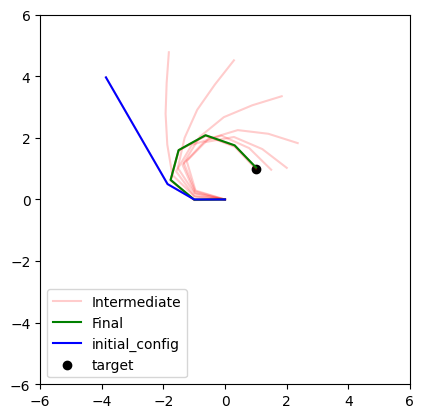

In [ ]:
from mp1 import ik_loss_with_obstacles
from main import run_optimization_and_save_intermediates

num_joints = 6 # what if you made this 6?
arm_lengths = np.ones(num_joints)
arm = Arm(arm_lengths=arm_lengths)

# let's say we want the end effector to be at (1, 1)
target = np.array([1, 1])
# obstacles are circles with (x, y, radius)
obstacles = np.array([[-1.5, 1.5, 0.5]])
# draw the obstacles
for obstacle in obstacles:
    plt.gca().add_patch(plt.Circle(obstacle[:2], obstacle[2], color='red', alpha=0.2))

# we sample num_sample_near configurations to estimate the gradient at each point
num_sample_near = 30
# our gradient with respect to a config
# loss = lambda config: ik_loss(arm, config, target)
loss = lambda config: ik_loss_with_obstacles(arm, config, target, obstacles)
get_gradient = lambda config: estimate_ik_gradient(loss, config, num_samples=num_sample_near)

# we specifically start the arm to the left of the obstacle
config_init = np.array([180, 30, 30])
if num_joints == 6:
    config_init = np.array([180, 30, 30, 0,0,0])

learning_rate = 1.0
total_iters = 2000

# this is some code from main.py that runs the optimization and saves intermediate steps
optim = lambda A_init, num_iterations: gradient_descent(
            get_gradient=get_gradient,
            A_init=A_init, 
            learning_rate=learning_rate, 
            num_iterations=num_iterations)
A_vals = run_optimization_and_save_intermediates(
    optim, config_init, total_iters=total_iters, plot_iters=20)

for i, A_val in enumerate(A_vals):
    plot_params = {"color": 'red', "alpha": 0.2}
    if i == 0:
        plot_params["label"] = "Intermediate"
    if i == len(A_vals) - 1:
        plot_params = {"color": 'green', "label": "Final"}
    arm.draw_config(plt.gca(), A_val, **plot_params)
# plot
arm.draw_space(plt.gca())
arm.draw_config(plt.gca(), config_init, color='blue', label='initial_config')
plt.scatter(target[0], target[1], color='black', label='target')
plt.legend()
plt.show()

Feel free to play around with the loss function and obstacles... If you give the arm 6 joints does it still get to its goal (change the num_joints to 6)? Can you make it still get to the goal (e.g., try multiplying the obstacle loss by 100 in the `ik_loss_with_obstacles` function...)?

Note: this is not necessary for passing our tests and is purely for your own enjoyment.

Congratulations, you should now be able to submit mp1.py on Gradescope and get 100%.